In [44]:
# Importing the packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Loading and processing the data

# Determining the path to the data
file_dir = os.path.dirname(os.path.realpath('naive_persistence.ipynb'))
python_dir = os.path.dirname(file_dir)
data_folder = os.path.join(python_dir, 'Data')
data_file = os.path.join(data_folder, 'combined_data_cleaned.csv')

# Loading the data
df = pd.read_csv(data_file, decimal = ',')
df_new = df[["TimeUTC", "DKZone", "DKPrice"]]

# Format for the datetime
date_format = '%Y-%m-%d %H:%M:%S'

# Filtering for DK1 price zone
df_DK1 = df_new[df_new['DKZone'] == 'DK1']
df_DK1 = df_DK1.drop('DKZone', axis = 1)
df_DK1.reset_index(drop=True, inplace=True)

# Saving datetime format for DK1
temp_list = []
for i in list(df_DK1["TimeUTC"]):
    n = 19
    j = i[:n]
    k = datetime.strptime(j, date_format)
    temp_list.append(k)
df_DK1.insert(0, "Time", temp_list, True)
df_DK1 = df_DK1.drop("TimeUTC", axis = 1)
df_DK1['DKPrice'] = df_DK1['DKPrice'].astype(float)

# Splitting between initial train and test set for DK1
DK1_train_set = df_DK1.loc[df_DK1['Time'] < pd.Timestamp('2025-01-01')]
DK1_train_set.reset_index(drop=True, inplace=True)
DK1_test_set = df_DK1.loc[df_DK1['Time'] >= pd.Timestamp('2025-01-01')]
DK1_test_set.reset_index(drop=True, inplace=True)

# Printing the shape for training and test date for DK1
print(f"Training data shape (DK1): {DK1_train_set.shape}")
print(f"Test data shape (DK1): {DK1_test_set.shape}")
print(f"Test set fraction (DK1): {len(DK1_test_set)/len(DK1_train_set):.2%}")

# Filtering for DK2 price zone
df_DK2 = df_new[df_new['DKZone'] == 'DK2']
df_DK2 = df_DK2.drop('DKZone', axis = 1)
df_DK2.reset_index(drop=True, inplace=True)

# Saving datetime format for DK2
temp_list = []
for i in list(df_DK2["TimeUTC"]):
    n = 19
    j = i[:n]
    k = datetime.strptime(j, date_format)
    temp_list.append(k)
df_DK2.insert(0, "Time", temp_list, True)
df_DK2 = df_DK2.drop("TimeUTC", axis = 1)
df_DK2['DKPrice'] = df_DK2['DKPrice'].astype(float)

# Splitting between initial train and test set for DK2
DK2_train_set = df_DK2.loc[df_DK1['Time'] < pd.Timestamp('2025-01-01')]
DK2_train_set.reset_index(drop=True, inplace=True)
DK2_test_set = df_DK2.loc[df_DK1['Time'] >= pd.Timestamp('2025-01-01')]
DK2_test_set.reset_index(drop=True, inplace=True)

# Printing the shape for training and test date for DK2
print(f"Training data shape (DK2): {DK2_train_set.shape}")
print(f"Test data shape (DK2): {DK2_test_set.shape}")
print(f"Test set fraction (DK2): {len(DK2_test_set)/len(DK2_train_set):.2%}")

Training data shape (DK1): (78911, 3)
Test data shape (DK1): (8760, 3)
Test set fraction (DK1): 11.10%
Training data shape (DK2): (78911, 3)
Test data shape (DK2): (8760, 3)
Test set fraction (DK2): 11.10%


In [39]:
# Defining the persistence model
def model_persistence(x):
    return x

In [ ]:
def perform_walk_forward_validation_naive(
        data_series, 
        model, 
        training_window = 8760, # 365 days of data - hours of data trained on
        forecast_horizon = 168, # 1 week - hours of data predicted
        ):
    """
    Walk-forward validation for Naive Persistence.
    """

    all_predictions = []
    all_actuals = []
    all_fold_rmse = []
    all_fold_mae = []

    # Calculate number of folds
    num_folds = (len(data_series) - training_window - forecast_horizon) // forecast_horizon

    print(f"Total folds: {num_folds}")
    print(f"Training winow: {training_window} hours")
    print(f"Forecast horizon: {forecast_horizon} hours")

    for fold in range(num_folds):
        start = fold * forecast_horizon

        # Check if there is enough data 
        if start + training_window + forecast_horizon > len(data_series):
            break
        
        print(f"Fold {fold + 1}/{num_folds}")

        # Split the data into training and validating data
        train_data = data_series[start: start + training_window]
        val_data = data_series[start + training_window: start + training_window + forecast_horizon]

        # Using the naive persistence model
        predicted_value = model(train_data.iloc[-1])
        predictions = np.full(len(val_data), predicted_value)
        actuals = val_data.values

        # Calculate errors
        fold_mse = mean_squared_error(actuals, predictions)
        fold_rmse = np.sqrt(fold_mse)
        fold_mae = mean_absolute_error(actuals, predictions)

        all_fold_rmse.append(fold_rmse)
        all_fold_mae.append(fold_mae)
        all_predictions.extend(predictions)
        all_actuals.extend(actuals)

        print(f"Fold RMSE: {fold_rmse:.2f}, MAE: {fold_mae:.2f}\n")
    
    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_mae = mean_absolute_error(all_actuals, all_predictions)

    print(f"Overall RMSE: {overall_rmse:.2f}")
    print(f"Overall MAE: {overall_mae:.2f}")
    print(f"Average fold RMSE: {np.mean(all_fold_rmse):.2f} (+/- {np.std(all_fold_rmse):.2f})")
    print(f"Average fold MAE: {np.mean(all_fold_mae):.2f} (+/- {np.std(all_fold_mae):.2f})\n")

    return all_predictions, all_actuals, all_fold_rmse, all_fold_mae

In [49]:
def plot_walk_forward_results(
        predictions, 
        actuals, 
        title,
        training_window = 8760, # 365 days of data - hours of data trained on
        forecast_horizon = 168, # 1 week - hours of data predicted
        ):
    """
    Plot walk-forward validation results.
    """
    plt.figure(figsize=(15, 6))
    
    # Create x-axis (fold numbers repeated for each prediction in that fold)
    x = []
    fold_num = 0
    for i in range(len(predictions)):
        if i % (forecast_horizon) == 0 and i > 0:
            fold_num += 1
        x.append(fold_num)
    
    plt.plot(actuals, label='Actual', alpha=0.7, linewidth=2)
    plt.plot(predictions, label='Predicted', alpha=0.7, linewidth=2)
    
    # Add vertical lines to separate folds
    for i in range(0, len(predictions), forecast_horizon):
        plt.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    plt.xlabel('Time Step')
    plt.ylabel('Electricity Price (DKK)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [51]:
# Walk-forward validation
model = model_persistence

# Walk-forward validation for DK1
data_series_DK1 = DK1_train_set['DKPrice']
predictions_DK1, actuals_DK1, rmse_DK1, mae_DK1 = perform_walk_forward_validation_naive(data_series_DK1, model)

# Walk-forward validation for DK2
data_series_DK2 = DK2_train_set['DKPrice']
predictions_DK2, actuals_DK2, rmse_DK2, mae_DK2 = perform_walk_forward_validation_naive(data_series_DK2, model)

Total folds: 416
Training winow: 8760 hours
Forecast horizon: 168 hours
Fold 1/416
Fold RMSE: 140.97, MAE: 127.20

Fold 2/416
Fold RMSE: 49.73, MAE: 32.39

Fold 3/416
Fold RMSE: 90.30, MAE: 36.76

Fold 4/416
Fold RMSE: 39.03, MAE: 25.50

Fold 5/416
Fold RMSE: 36.95, MAE: 25.07

Fold 6/416
Fold RMSE: 57.82, MAE: 30.81

Fold 7/416
Fold RMSE: 46.56, MAE: 21.06

Fold 8/416
Fold RMSE: 102.08, MAE: 58.40

Fold 9/416
Fold RMSE: 58.79, MAE: 36.65

Fold 10/416
Fold RMSE: 67.66, MAE: 43.81

Fold 11/416
Fold RMSE: 57.57, MAE: 30.63

Fold 12/416
Fold RMSE: 141.52, MAE: 128.66

Fold 13/416
Fold RMSE: 38.92, MAE: 26.06

Fold 14/416
Fold RMSE: 76.08, MAE: 46.17

Fold 15/416
Fold RMSE: 41.79, MAE: 20.10

Fold 16/416
Fold RMSE: 57.58, MAE: 33.69

Fold 17/416
Fold RMSE: 230.81, MAE: 212.41

Fold 18/416
Fold RMSE: 85.51, MAE: 44.02

Fold 19/416
Fold RMSE: 39.94, MAE: 26.45

Fold 20/416
Fold RMSE: 36.13, MAE: 26.21

Fold 21/416
Fold RMSE: 70.55, MAE: 55.52

Fold 22/416
Fold RMSE: 67.32, MAE: 53.22

Fold 2

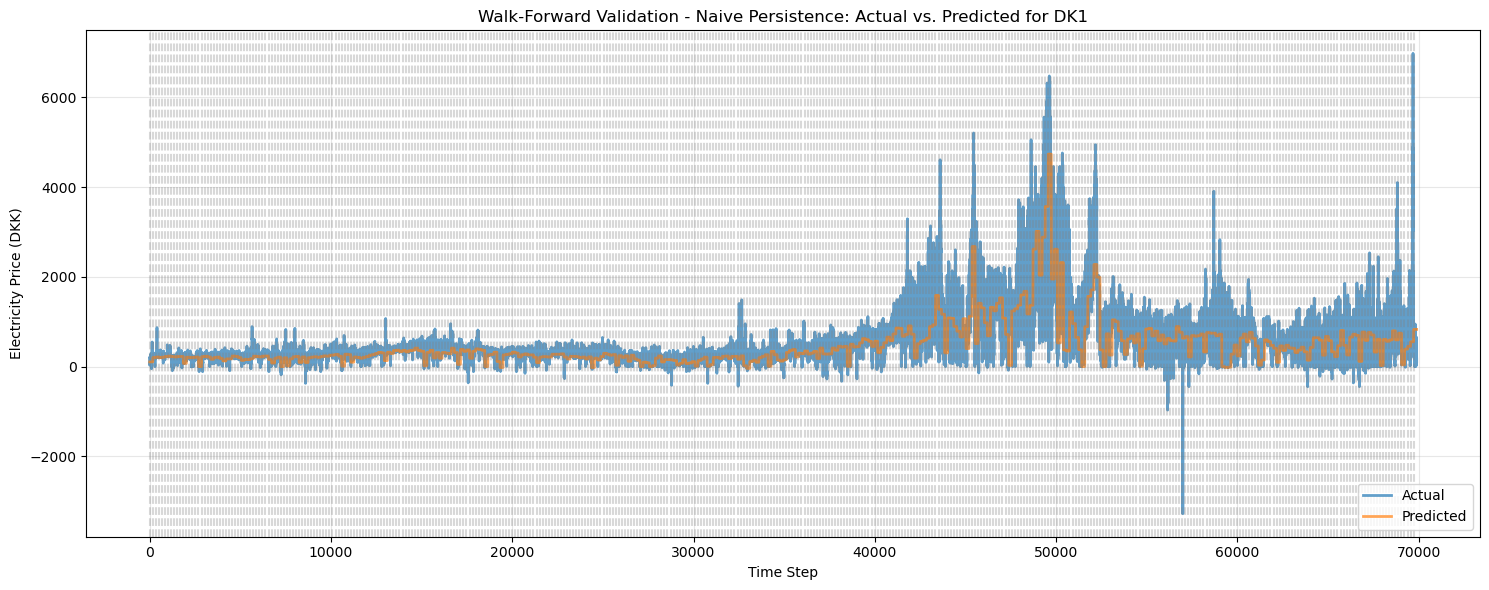

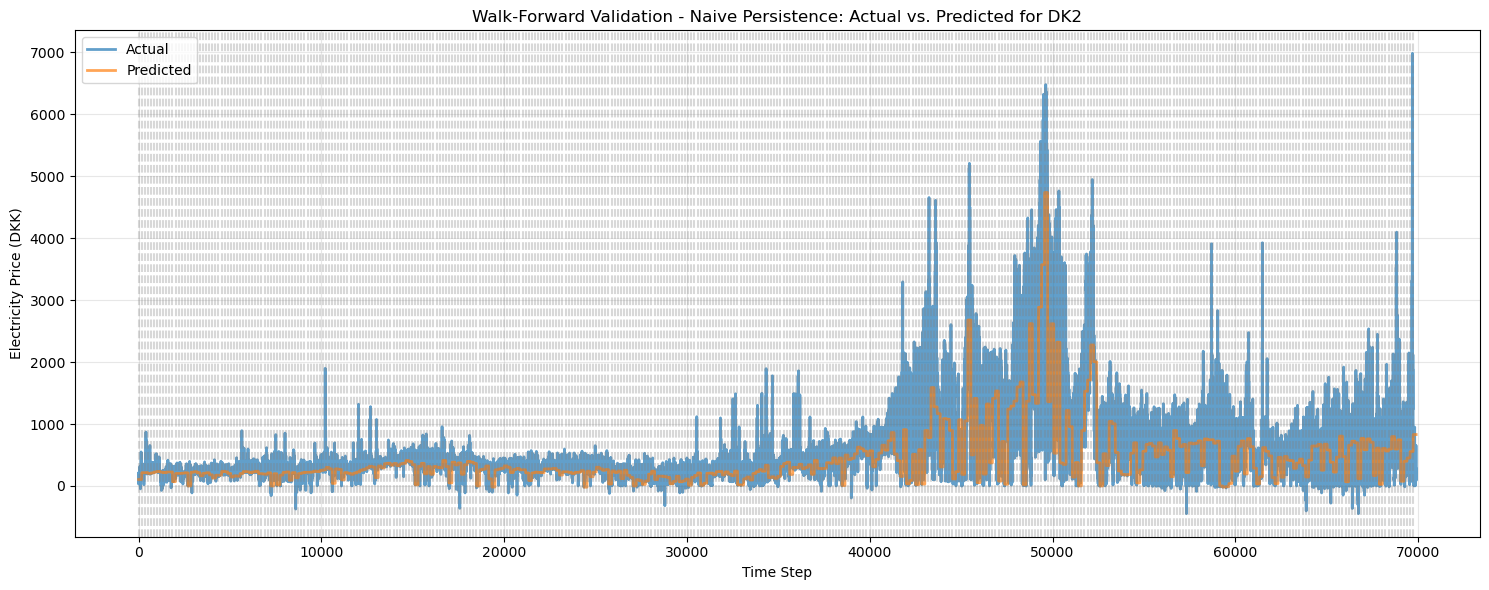

In [52]:
title_DK1 = 'Walk-Forward Validation - Naive Persistence: Actual vs. Predicted for DK1'

plot_walk_forward_results(
        predictions_DK1, 
        actuals_DK1, 
        title_DK1)

title_DK2 = 'Walk-Forward Validation - Naive Persistence: Actual vs. Predicted for DK2'

plot_walk_forward_results(
        predictions_DK2, 
        actuals_DK2, 
        title_DK2)